## Imports

In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
import numpy 

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score
from sklearn.linear_model import LogisticRegression
from sys import getsizeof

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [3]:
scorer = make_scorer(f1_score, needs_proba=False,
                     greater_is_better=True,average='micro')

## Data import

In [4]:
df = pd.read_csv('../input/train_values.csv')
train_target = pd.read_csv('../input/train_labels.csv')

In [5]:
Counter(train_target.damage_grade)

Counter({3: 87218, 2: 148259, 1: 25124})

In [6]:
cat_cols = df.columns[df.dtypes == 'object']

num_cols = [i for i in df.columns if i not in cat_cols]

X_train = pd.get_dummies(df, columns=cat_cols)

X_test = pd.read_csv('../input/test_values.csv')

X_test = pd.get_dummies(X_test , columns=cat_cols)

y = train_target.damage_grade

## Utils

In [44]:
def give_sub_file(preds, ids, path='../output/preds.csv'):
    preds = pd.DataFrame(preds,columns=['damage_grade'])
    preds['building_id'] = ids
    preds = preds[['building_id', 'damage_grade']]
    print(preds.columns)
    print(preds.shape)
    preds.to_csv(path, index=False)


In [ ]:
# preds = estimator.predict(X_test)
# give_sub_file(preds, X_test.building_id.tolist())

## Class distribution

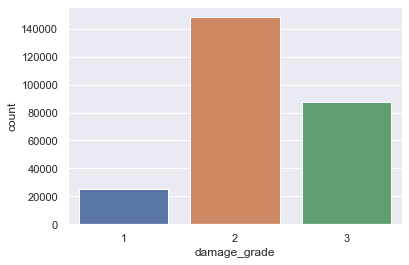

In [11]:
sns.set(style="darkgrid")

ax = sns.countplot(x="damage_grade", data=train_target)

In [15]:
# Metric to be used
# F1 score with argument micro has to be used

In [16]:
from sklearn.metrics import f1_score

f1_score(y_true= , y_pred = average='micro')

## Base line model always predict mode ( class = 2 ) 

In [18]:
# lets see our f1 score (micro) when we always predict the 2nd class

In [19]:
y_true =  train_target.damage_grade
y_pred = [2]*len(y_true)

In [20]:
f1_score(y_true, y_pred, average='micro')

0.5689118614280068

Number 1 on leaderboard score = 0.7544

## check features

In [6]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


Feature Description

https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

### Does buliding ID give us something

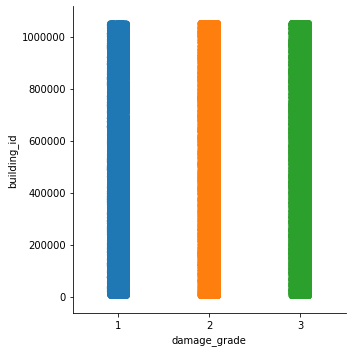

In [16]:
sns.catplot(x="damage_grade", y="building_id", data=train_target);

## Linear model

In [ ]:
estimator = LogisticRegression(random_state=0, solver='lbfgs',
...                          multi_class='multinomial')

In [77]:
# size increase by 7 times when convert number to string 

In [80]:
cross_val_score(estimator=estimator,X = X_train, y=y_train, scoring=scorer, cv=3)

array([0.56890915, 0.56890915, 0.56891729])

In [81]:
# Pretty much useless

In [88]:
cross_val_score(estimator=estimator,X = X_train[['count_floors_pre_eq','age']], y=y_train, scoring=scorer, cv=3)

array([0.56831054, 0.56859833, 0.56833017])

## Random Forest

In [65]:
X = df.copy()

In [66]:
x1 = X[cat_cols].apply(LabelEncoder().fit_transform)

In [67]:
X = pd.concat([X[num_cols], x1], axis=1)

In [11]:
estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)

In [12]:
cross_val_score(estimator=estimator,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.71525763, 0.71781323, 0.71927704])

In [16]:
np.mean(np.array([0.71525763, 0.71781323, 0.71927704]))

0.7174493000000001

`estimator = RandomForestClassifier(n_estimators=10,min_samples_leaf=1)`  array([0.69160105, 0.69367316, 0.69515916])

`estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)`  array([0.71525763, 0.71781323, 0.71927704])

` RandomForestClassifier(n_estimators=30,min_samples_leaf=1) ` [0.71034213, 0.71319703, 0.71529385] 

` random on one-hot encoding `
array([0.65804439, 0.65726159, 0.6648017 ])

In [27]:
from sklearn.model_selection import train_test_split
from rfpimp import *

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=0)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208480, 39), (52121, 39), (208480,), (52121,))

In [30]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)

In [31]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

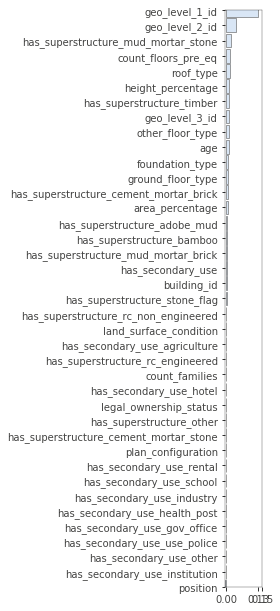

In [32]:
imp = importances(model, X_test, y_test) # permutation
viz = plot_importances(imp)

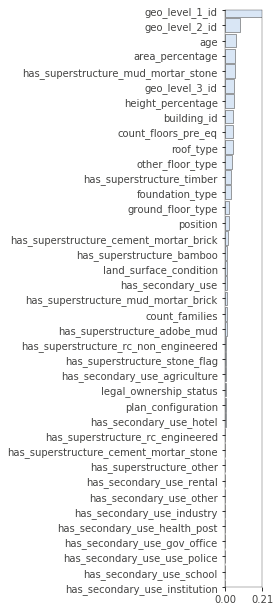

In [26]:
imp = importances(model, X_train, y_train) # permutation
viz = plot_importances(imp)

In [51]:
top30_features = imp.index[:30]

In [46]:
# use only top 10 features

In [52]:
cross_val_score(estimator=model,X = pd.concat([X_train, X_test])[top30_features], y=pd.concat([y_train, y_test]), scoring=scorer, cv=3,n_jobs=-1)

array([0.72173873, 0.72112861, 0.71864387])

In [54]:
# <70 for top 10 features
# 72.2 for top 20 features
# 72.2 for top 30 features


In [55]:
# are there any better ways to represent features.

In [56]:
imp.index[:10]

Index(['geo_level_1_id', 'geo_level_2_id',
       'has_superstructure_mud_mortar_stone', 'count_floors_pre_eq',
       'roof_type', 'height_percentage', 'has_superstructure_timber',
       'geo_level_3_id', 'other_floor_type', 'age'],
      dtype='object', name='Feature')

In [64]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [68]:
geo =  X[geo_features]

geo_level_1_id       31
geo_level_2_id     1414
geo_level_3_id    11595
dtype: int64

## XGBOOST

In [16]:
from xgboost import XGBClassifier

In [17]:
xgb = XGBClassifier(n_estimators=30,subsample=0.3)

In [18]:
cross_val_score(estimator=xgb,X = X_train, y=y_train, scoring=scorer, cv=3,n_jobs=-1)

array([0.64708523, 0.64614127, 0.64909918])